### Import required packages

In [1]:
import random
import math
import matplotlib.pyplot as plt
import numpy as np

### Load and renewable generation is taken from village Palari in Chhattisgarh (cite: Paper)

In [2]:
# Daily load is taken out from the paper
load_profile = [18, 5, 5, 5, 5, 1, 7, 3, 4, 22, 24, 25, 26, 27, 28, 27, 23, 21, 32, 27, 34, 24, 25, 20]

# Wind energy is also from the paper as an random function
wind = [random.randint(2,10) for _ in range(24)]

# Solar as shown in the paper is a half sinusoidal function between 6am to 6pm
# Generate 12 points between 0 and pi (half of the sine wave)
x = np.linspace(0, np.pi, 12)

# Apply the sine function to get a half-sinusoidal distribution
sinusoidal_values = np.sin(x)

# Normalize the values to a specific range if needed (optional)
# For example, scaling between 0 and 1
normalized_values = sinusoidal_values / np.max(sinusoidal_values)

# Peak Solar power is taken as 20KW
solar = np.round(normalized_values,2) * 20

# Non Solar hours added
solar = [0] * 6 + solar.tolist() + [0] * 6

# Hourly Renewable generation from wind and solar
renewable_generation = [a+round(b,1) for (a,b) in zip(wind,solar)]

print(f'Hourly wind generation: {wind}')
print(f'Hourly solar generation: {solar}')


Hourly wind generation: [3, 9, 3, 7, 5, 9, 6, 3, 7, 8, 6, 8, 6, 10, 4, 4, 7, 8, 8, 9, 7, 3, 2, 8]
Hourly solar generation: [0, 0, 0, 0, 0, 0, 0.0, 5.6000000000000005, 11.0, 15.2, 18.400000000000002, 20.0, 20.0, 18.400000000000002, 15.2, 11.0, 5.6000000000000005, 0.0, 0, 0, 0, 0, 0, 0]


### To microgrid add a micro reactor with adjustable output

In [7]:
# Introduce Nuclear Power. Assumed it to have load following properties from 50% to 100%
nuclear_min = 5  # Minimum nuclear power
nuclear_max = 10  # Maximum nuclear power

### Also add a Battery storage to cater for low Renewables generations

In [8]:
# Introduce Storage device
battery_capacity = 80  # Total battery capacity
battery_soc = 0.37 * battery_capacity  # Initial state of charge (37% of capacity)
battery_max_charge_rate = 10  # Assume a maximum charge rate of 10 units/hour
battery_max_discharge_rate = 10  # Assume a maximum discharge rate of 10 units/hour


#### The goal is to simulate the power balance in a microgrid with solar, wind, nuclear, and battery storage based on a given load profile.
#### Steps:
#### 1. Adjust nuclear power to minimize excess energy when renewable generation exceeds load + battery charging capacity.
#### 2. Track battery SOC (state of charge) throughout the day.
#### 3. Ensure load is served by a combination of renewables, nuclear, and battery power.


In [9]:
# Initialise list to store results
nuclear_power_output = []
battery_soc_history = []
excess_energy_history = []

# Do hourly analysis for a typical day
for hour in range(24):
    # Calculate the initial required nuclear power assuming no excess. 
    # 1. Calculate minimum requirement of deficit and maximum nuke power
    # 2. If it's less than nuke minimum, then choose nuke minimum
    nuclear_power = max(nuclear_min, min(nuclear_max, load_profile[hour] - renewable_generation[hour]))
    
    # Check the total available generation (renewable + nuclear)
    total_generation = renewable_generation[hour] + nuclear_power
    
    # If generation exceeds load and battery charging, adjust nuclear to minimize excess
    excess_energy = total_generation - load_profile[hour]
    # print(excess_energy)

    # Excess energy to be used for battery charging
    if excess_energy > 0:
        # Calculate the amount of energy that can be stored in the battery
        available_battery_capacity = battery_capacity - battery_soc
        # We can charge the battery only to the maximum charging rate
        charge_to_battery = min(excess_energy, available_battery_capacity, battery_max_charge_rate)
        battery_soc += charge_to_battery
        excess_energy -= charge_to_battery
        
    # If generation is less than the load, discharge battery if possible
    elif total_generation < load_profile[hour]:
        deficit_energy = load_profile[hour] - total_generation
        # Limit the discharge to maximum discharge rate of battery
        discharge_from_battery = min(deficit_energy, battery_soc, battery_max_discharge_rate)
        battery_soc -= discharge_from_battery
        deficit_energy -= discharge_from_battery
        # Generation could not match the load
        if deficit_energy > 0:
            excess_energy = -1
        else:
            excess_energy = 0
        
    # Store the results for each hour
    nuclear_power_output.append(round(nuclear_power,1))
    battery_soc_history.append(round(battery_soc,1))
    excess_energy_history.append(round(excess_energy,1))
    deficit_hours = excess_energy_history.count(-1)
    wasted_energy = [a if a>0 else 0 for a in excess_energy_history]

# Convert results to numpy arrays for easier analysis
# nuclear_power_output = np.array(nuclear_power_output)
# battery_soc_history = np.array(battery_soc_history)
# excess_energy_history = np.array(excess_energy_history)

print(f'Hourly renewable generation: {renewable_generation}')
print(f'Hourly Load: {load_profile}')
print(f'Nuclear Power Generated: {nuclear_power_output}')
print(f'Battery State of Charge: {battery_soc_history}')
print(f'Excess charge history: {excess_energy_history}')
print(f'Hours of power cut: {deficit_hours}')
print(f'Unutilised energy: {round(sum(wasted_energy),2)}')

Hourly renewable generation: [3, 9, 3, 7, 5, 9, 6.0, 8.6, 18.0, 23.2, 24.4, 28.0, 26.0, 28.4, 19.2, 15.0, 12.6, 8.0, 8, 9, 7, 3, 2, 8]
Hourly Load: [18, 5, 5, 5, 5, 1, 7, 3, 4, 22, 24, 25, 26, 27, 28, 27, 23, 21, 32, 27, 34, 24, 25, 20]
Nuclear Power Generated: [10, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8.8, 10, 10, 10, 10, 10, 10, 10, 10, 10]
Battery State of Charge: [24.6, 33.6, 36.6, 43.6, 48.6, 58.6, 62.6, 72.6, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 78.0, 77.6, 74.6, 64.6, 56.6, 46.6, 36.6, 26.6, 24.6]
Excess charge history: [0, 0, 0, 0, 0, 3, 0.0, 0.6, 11.6, 6.2, 5.4, 8.0, 5.0, 6.4, 0.0, 0, 0, 0, -1, 0, -1, -1, -1, 0]
Hours of power cut: 4
Unutilised energy: 46.2


### Plot the results

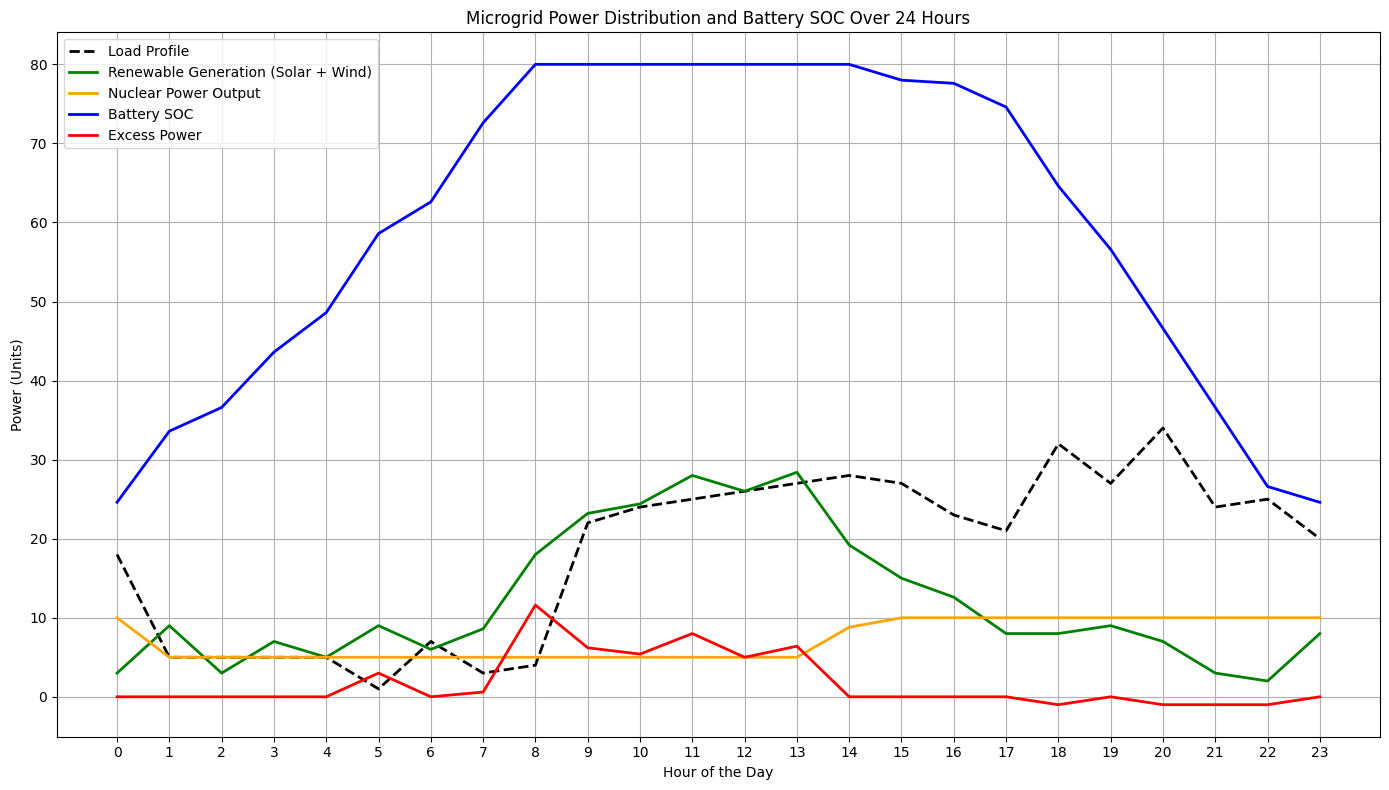

In [10]:
# Time axis for the 24-hour period
hours = [i for i in range(len(load_profile))]

# Plot the load profile, renewable generation, and nuclear power output
plt.figure(figsize=(14, 8))

# Load Profile
plt.plot(hours, load_profile, label='Load Profile', color='black', linewidth=2, linestyle='--')
# Renewable Generation (Solar + Wind)
plt.plot(hours, renewable_generation, label='Renewable Generation (Solar + Wind)', color='green', linewidth=2)
# Nuclear Power Output
plt.plot(hours, nuclear_power_output, label='Nuclear Power Output', color='orange', linewidth=2)
# Battery SOC
plt.plot(hours, battery_soc_history, label='Battery SOC', color='blue', linewidth=2)
# Excess Power
plt.plot(hours, excess_energy_history, label='Excess Power', color='red', linewidth=2)

# Add grid, legend, and labels
plt.grid(True)
plt.legend(loc='upper left')
plt.xlabel('Hour of the Day')
plt.ylabel('Power (Units)')
plt.title('Microgrid Power Distribution and Battery SOC Over 24 Hours')
plt.xticks(hours)  # Mark every hour

# Show the plot
plt.tight_layout()
plt.show()
